In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("src")

from energy_es.data import get_prices

In [3]:
# Get prices
prices = get_prices()

In [4]:
# Get current day
d = prices[0]["datetime"].strftime("%Y-%m-%d")

In [5]:
# Create X axis values
x = list(map(lambda x: x["datetime"].strftime("%H:%M"), prices))
x = np.array(x)

# Create Y axis values
y = list(map(lambda x: x["value"], prices))
y = np.array(y)

In [6]:
# Get minimum price
min_y = y.min()
min_x = x[y.argmin()]

# Get maximum price
max_y = y.max()
max_x = x[y.argmax()]

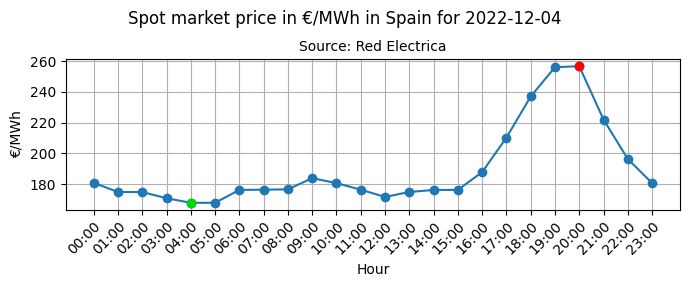

In [7]:
# Create chart
fig, ax = plt.subplots(figsize=(7, 3))
fig.suptitle(f"Spot market price in €/MWh in Spain for {d}", y=0.94)

ax.set_title("Source: Red Electrica", fontdict={"fontsize": 10})
ax.plot(x, y, marker="o")
ax.scatter([min_x], [min_y], c="#00d800", zorder=2)
ax.scatter([max_x], [max_y], c="#ff0000", zorder=2)

ax.set(xlabel="Hour", ylabel="€/MWh")
ax.grid()

plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.show()